<a href="https://colab.research.google.com/github/Catgodesxd/Cat-Breed-Classification/blob/main/Cat_Breed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cat Breed Classification

##Download Dependencies and Import Libraries

In [18]:
!pip install torch torchvision timm --quiet
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from PIL import Image
import torch, torch.nn as nn, torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_B3_Weights
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
import numpy as np
import timm
from google.colab import files


##Import Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shawngano/gano-cat-breed-image-collection")

print("Path to dataset files:", path)

100%|██████████| 254M/254M [00:02<00:00, 116MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shawngano/gano-cat-breed-image-collection/versions/3


##Example From Dataset

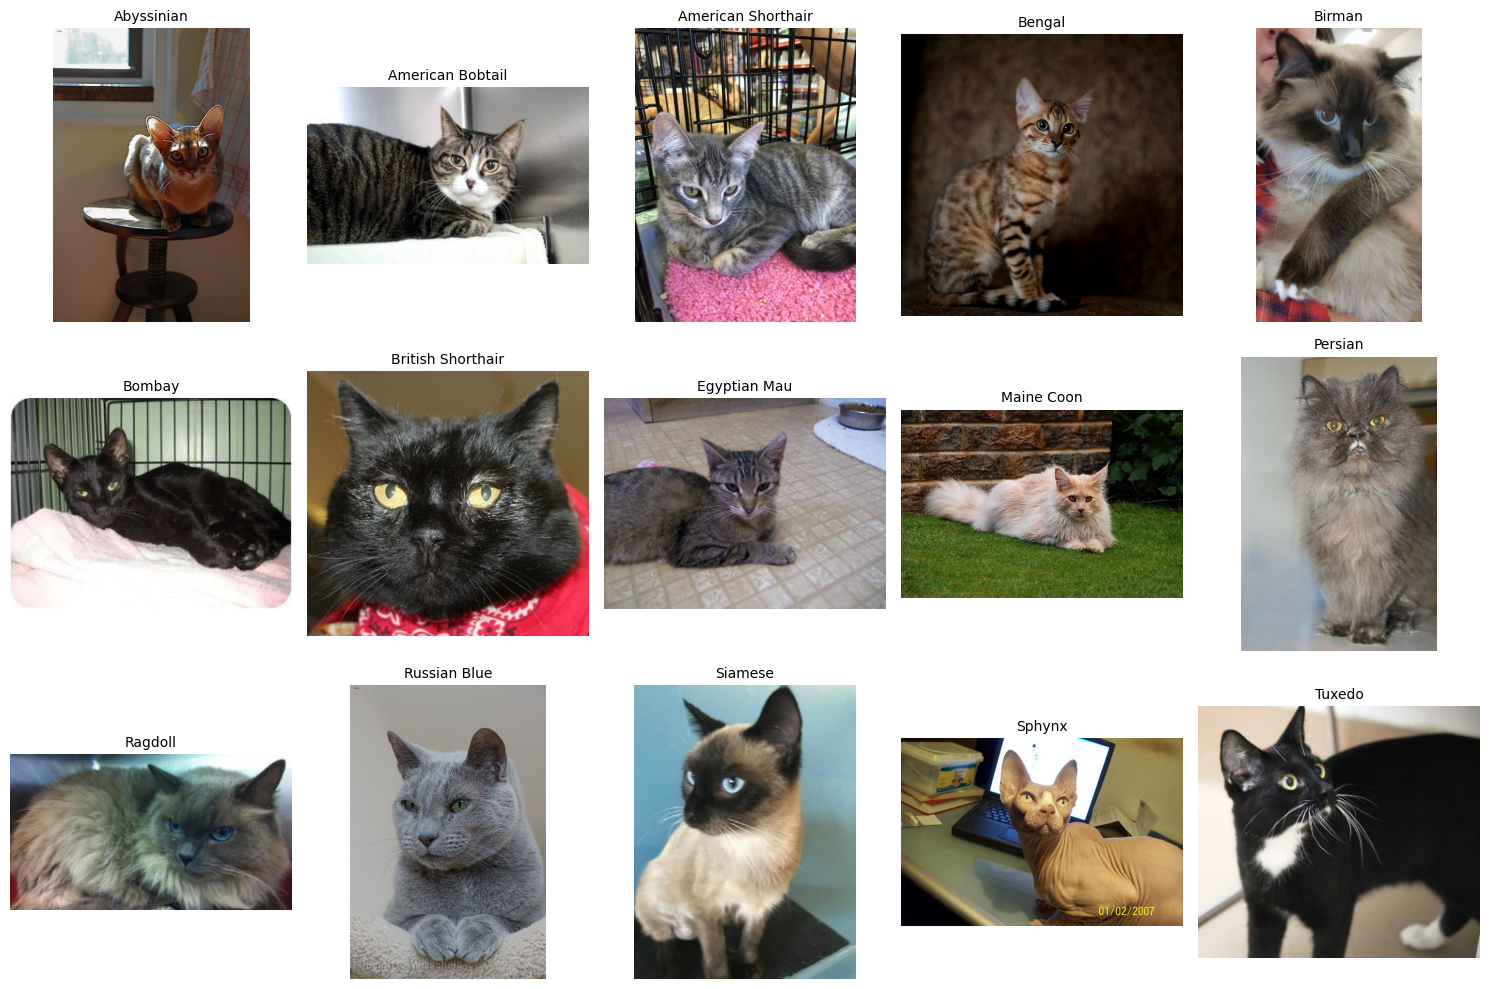

In [3]:
dataset_path = "/root/.cache/kagglehub/datasets/shawngano/gano-cat-breed-image-collection/versions/3/Gano-Cat-Breeds-V1_1"

breeds = [
    "Abyssinian", "American Bobtail", "American Shorthair", "Bengal",
    "Birman", "Bombay", "British Shorthair", "Egyptian Mau",
    "Maine Coon", "Persian", "Ragdoll", "Russian Blue",
    "Siamese", "Sphynx", "Tuxedo"
]

plt.figure(figsize=(15, 10))

for i, breed in enumerate(breeds):
    breed_path = os.path.join(dataset_path, breed)

    images = [f for f in os.listdir(breed_path)]

    img_path = os.path.join(breed_path, random.choice(images))
    img = Image.open(img_path)

    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(breed, fontsize=10)

plt.tight_layout()
plt.show()


##Training & Model

Classes: ['Abyssinian', 'American Bobtail', 'American Shorthair', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx', 'Tuxedo']
Epoch [1/80] TrainLoss=2.7168  ValLoss=2.6436  ValAcc=19.73%
Epoch [2/80] TrainLoss=2.6222  ValLoss=2.5014  ValAcc=40.44%
Epoch [3/80] TrainLoss=2.4770  ValLoss=2.2701  ValAcc=56.27%
Epoch [4/80] TrainLoss=2.2955  ValLoss=1.9763  ValAcc=60.80%
Epoch [5/80] TrainLoss=2.1014  ValLoss=1.7464  ValAcc=63.47%
Epoch [6/80] TrainLoss=1.9890  ValLoss=1.6084  ValAcc=66.13%
Epoch [7/80] TrainLoss=1.9041  ValLoss=1.5169  ValAcc=68.44%
Epoch [8/80] TrainLoss=1.8627  ValLoss=1.4272  ValAcc=72.18%
Epoch [9/80] TrainLoss=1.7954  ValLoss=1.3733  ValAcc=72.71%
Epoch [10/80] TrainLoss=1.8043  ValLoss=1.3375  ValAcc=74.76%
Epoch [11/80] TrainLoss=1.7655  ValLoss=1.3060  ValAcc=76.09%
Epoch [12/80] TrainLoss=1.7122  ValLoss=1.2858  ValAcc=74.93%
Epoch [13/80] TrainLoss=1.7075  ValLoss=1.2508  V

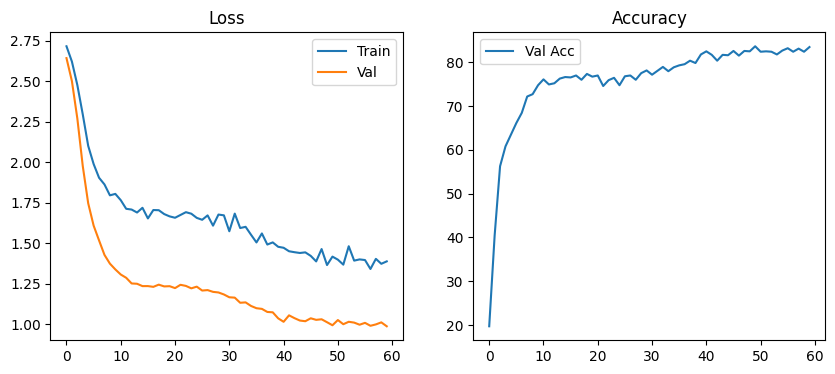

Best Validation Accuracy: 83.64%


In [6]:
# Dataset setup
dataset_path = "/root/.cache/kagglehub/datasets/shawngano/gano-cat-breed-image-collection/versions/3/Gano-Cat-Breeds-V1_1"

breeds = [
    "Abyssinian","American Bobtail","American Shorthair","Bengal",
    "Birman","Bombay","British Shorthair","Egyptian Mau",
    "Maine Coon","Persian","Ragdoll","Russian Blue",
    "Siamese","Sphynx","Tuxedo"
]
num_classes = len(breeds)

#Data augmentation & transforms (300×300)
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(300, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

#Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_tf)
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

# Create subsets with proper transforms
train_ds = Subset(full_dataset, train_indices.indices)
val_ds = Subset(full_dataset, val_indices.indices)

# Apply validation transform to val subset
class TransformSubset(Subset):
    def __init__(self, subset, transform):
        super().__init__(subset.dataset, subset.indices)
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

val_ds = TransformSubset(val_ds, val_tf)

# Compute balanced sampling weights from TRAIN indices only
targets = [full_dataset.targets[i] for i in train_indices.indices]
class_sample_count = np.array([targets.count(t) for t in range(num_classes)])
weights = 1.0 / class_sample_count
samples_weight = np.array([weights[t] for t in targets])
sampler = WeightedRandomSampler(torch.DoubleTensor(samples_weight), len(samples_weight))

train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

print("Classes:", full_dataset.classes)

# Load EfficientNet-B3 backbone
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = models.efficientnet_b3(weights=weights)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Replace classifier
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Training setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

# MixUp + CutMix
mixup_fn = timm.data.Mixup(mixup_alpha=0.2, cutmix_alpha=1.0, num_classes=num_classes)

#Train loop (with early stopping)
num_epochs = 80
best_acc = 0
patience, trigger = 10, 0   # early stopping patience
train_losses, val_losses, val_accs = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if torch.rand(1) < 0.5:
            imgs, labels = mixup_fn(imgs, labels)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_loss /= len(val_loader)
    acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(acc)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"TrainLoss={train_loss:.4f}  ValLoss={val_loss:.4f}  ValAcc={acc:.2f}%")

    # Early stopping
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_catbreed_b3.pth")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping triggered.")
            break

# Plot learning curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

print(f"Best Validation Accuracy: {best_acc:.2f}%")

In [7]:
torch.save(model, "catbreed_full_model.pth")
print("Full model saved as catbreed_full_model.pth")


Full model saved as catbreed_full_model.pth


In [10]:
files.download("catbreed_full_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Evaluation

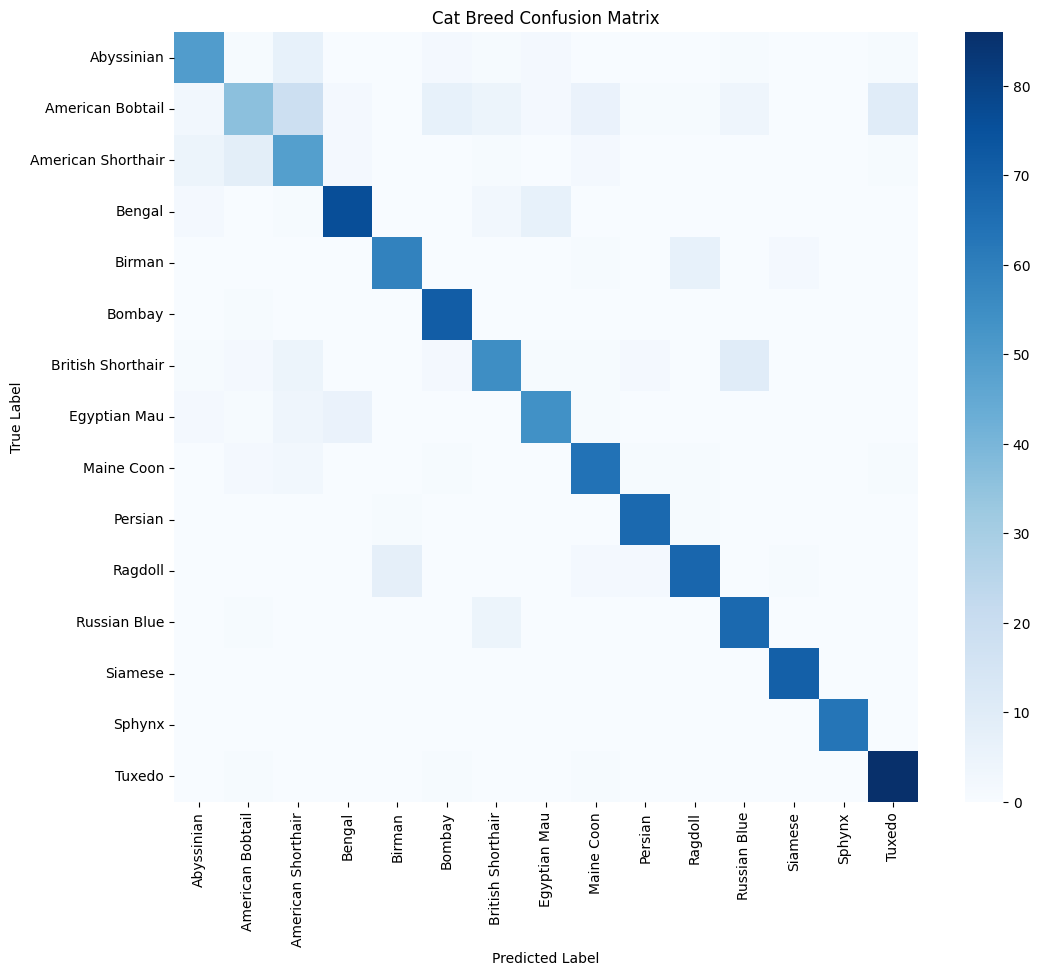

Classification Report:

                    precision    recall  f1-score   support

        Abyssinian      0.794     0.769     0.781        65
  American Bobtail      0.667     0.375     0.480        96
American Shorthair      0.557     0.710     0.624        69
            Bengal      0.884     0.854     0.869        89
            Birman      0.868     0.855     0.861        69
            Bombay      0.845     0.986     0.910        72
 British Shorthair      0.786     0.696     0.738        79
      Egyptian Mau      0.818     0.794     0.806        68
        Maine Coon      0.821     0.877     0.848        73
           Persian      0.918     0.971     0.944        69
           Ragdoll      0.872     0.840     0.855        81
      Russian Blue      0.817     0.918     0.865        73
           Siamese      0.959     1.000     0.979        70
            Sphynx      1.000     1.000     1.000        63
            Tuxedo      0.869     0.966     0.915        89

          accu

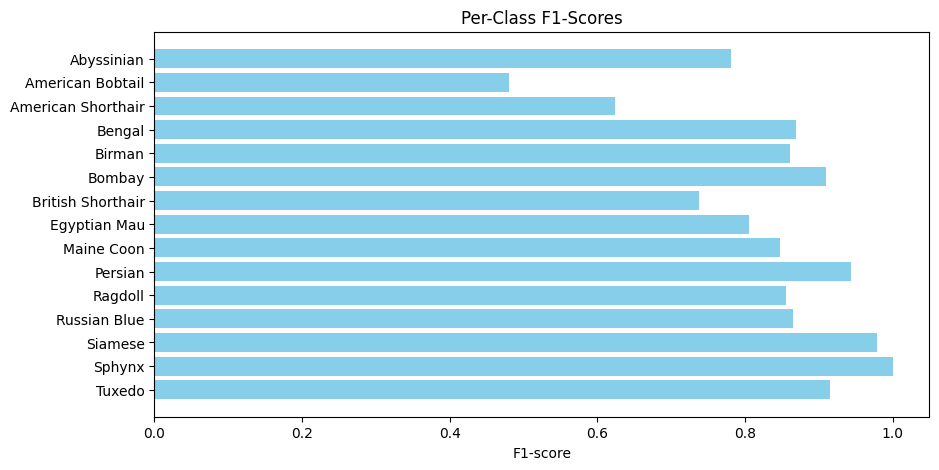

In [14]:
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=breeds, yticklabels=breeds)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Cat Breed Confusion Matrix")
plt.show()

#Classification Report (Precision / Recall / F1)
report = classification_report(all_labels, all_preds,
                               target_names=breeds,
                               digits=3, zero_division=0)
print("Classification Report:\n")
print(report)

#F1-score visualization
report_dict = classification_report(all_labels, all_preds,
                                    target_names=breeds,
                                    output_dict=True,
                                    zero_division=0)
f1_scores = [report_dict[b]['f1-score'] for b in breeds]

plt.figure(figsize=(10,5))
plt.barh(breeds, f1_scores, color='skyblue')
plt.xlabel("F1-score")
plt.title("Per-Class F1-Scores")
plt.gca().invert_yaxis()
plt.show()


##Using The Model

Saving 1655.jpg to 1655 (2).jpg
Saving Catgodesxd.jpg to Catgodesxd (1).jpg


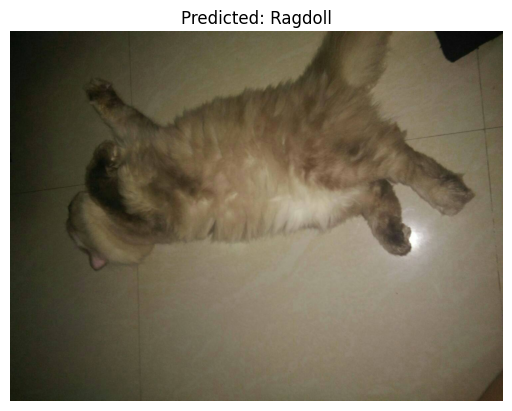

1655 (2).jpg
Top predictions:
   Ragdoll              : 34.15%
   Maine Coon           : 19.45%
   American Bobtail     : 12.45%


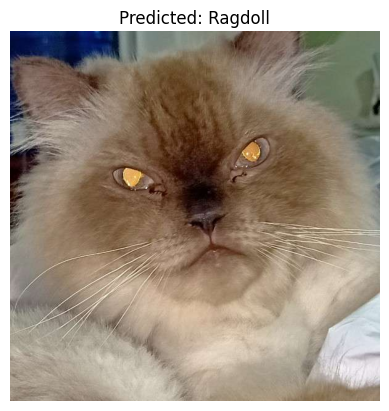

Catgodesxd (1).jpg
Top predictions:
   Ragdoll              : 47.49%
   Birman               : 17.18%
   Persian              : 16.02%


In [21]:
uploaded = files.upload()
filenames = list(uploaded.keys())

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

model.eval()

for image_path in filenames:
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        top3_prob, top3_catid = torch.topk(probabilities, 3)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {breeds[top3_catid[0]]}")
    plt.show()

    print(f"{image_path}")
    print("Top predictions:")
    for i in range(3):
        print(f"   {breeds[top3_catid[i]]:20s} : {top3_prob[i]*100:.2f}%")